# Malaria addInputEIR calibration

### A history matching approach to calibrating an empirical model of malaria infection and immunity

### In this version, we will be utilizing the full immune parameter space, sampling also which immune forces should be included in the calculation of the immune modifier (ie configurable params starting with "Immune_Modifier_Include*"

### For iter0 we will cut down parameter space by using the distribution of malaria prevalence by season, age and density bins from a moderate high transmission setting in Sugungum, Garki, Nigeria

# Import block

In [1]:
from IPython.extensions import autoreload
%load_ext autoreload
%autoreload 2
import os, glob, re, sys, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
import itertools
from calibtool.analyzers.Helpers import \
    convert_to_counts, age_from_birth_cohort, season_from_time, aggregate_on_index

from wand.image import Image as WImage
from history_matching import HistoryMatching, HistoryMatchingCut, quick_read, Basis

import pycuda
from IPython.display import IFrame, display

from pyDOE import lhs
from history_matching import HistoryMatching, HistoryMatchingCut, quick_read, Basis
sns.set(font_scale=2)
sns.set_style("white")

C:\conda\envs\history_matching\lib\site-packages\skcuda\cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


In [2]:
def fix_glob(pth):
    return re.sub('([\[\]])','[\\1]', pth)

# Configure parameters and data for history matching

In [3]:
site = 'Sugungum'
season_cut = 'W2'
age_bin_cut = 28
density_bin_cut = 50

cut_name = f'{density_bin_cut}_{age_bin_cut}_{season_cut}_{site}'

#iteration = int(re.search(r'iter(\d+)', os.getcwd())) # Index of the current iteration
iteration = 1 
#list of exp_ids/folders that correspond to exp_ids from which our emulation will draw
exp_ids = ['4e5108ee-2160-ea11-a2c5-c4346bcb1550'] # TODO: only uses first for now, should loop
basedir = 'C:\git\Malaria-Uganda-PRISM'
datafile = os.path.join('..','reference data', 'Garki_df.csv')

In [4]:
# The implausibility threshold determines how willing we are to retain regions
# of parameter space that are inconsistent with the underlying data. A higher
# threshold is more risk averse in that potentially good regions are less likely
# to be rejected, however it will take more iterations/simulations to achieve results.
implausibility_threshold = 3
training_fraction = 0.75 # Fraction of simulations to use as training
discrepancy_std = 0.0 # Accounts for uncertainty w.r.t model structure
n_samples_to_generate_for_next_iter = 1000 # Number of simulations to conduct on this iteration

In [5]:
# Here we define the parameter names and ranges
params_file = os.path.join('..','Params.xlsx')
param_info = quick_read(params_file, 'Params').set_index('Name')
param_names = param_info.index.tolist()

params = param_info.index.values
n_params = param_info.shape[0] # We'll use this one place later
display(param_info)

Reading Params from ..\Params_c686920dee8501a26fe576ed61915351.hd5


,Min,Max,MapTo
Name,,,
Biological_Age_Immune_Coefficient_PPP,0.0,10,Biological_Age_Immune_Coefficient_PPP
Biological_Age_Immune_Coefficient_TM,0.0,1,Biological_Age_Immune_Coefficient_TM
Cumulative_Exposure_Immune_Coefficient_PPP,0.0,10,Cumulative_Exposure_Immune_Coefficient_PPP
Cumulative_Exposure_Immune_Coefficient_TM,0.0,1,Cumulative_Exposure_Immune_Coefficient_TM
Scale_Factor_Age_a,3.0,5,Scale_Factor_Age_a
Parasite_Density_Wave_Sigma,0.6,6,Parasite_Density_Wave_Sigma
Immune_Modifier_Include_Age,0.0,1,Immune_Modifier_Include_Age
Immune_Modifier_Include_Cumulative_Exposure,0.0,1,Immune_Modifier_Include_Cumulative_Exposure


## Read in Sim Results

In [6]:
all_samples = []
all_results = []
for exp_id in exp_ids:
    
    print('-'*80, '\nExperiment:', exp_id)
    sim_results_fn = os.path.join(exp_id, 'full_analyzer_results.csv')
    print(sim_results_fn)
    sr = pd.read_csv(sim_results_fn, skipinitialspace=True)
    
    sr = sr[(sr.season == season_cut)&(sr.age_bin ==age_bin_cut)&(sr.density_bin==density_bin_cut)]
    print(sr.head())
    sr['Sample_Id'] = sr['sample'].apply(lambda x: '%s.%06d' % (exp_id, x))
    sr.rename(columns = {'sim_id': 'Sim_Id','value':'Result'}, inplace=True)
    all_results.append( sr )
    #read in tags making a samples.xlsx file 
    s = pd.read_excel(os.path.join(exp_id, 'Samples.xlsx'))
    # s.drop('Sim_Id', axis=1, inplace=True)
    s['Sample_Id'] = s['Sample'].apply(lambda x: '%s.%06d' % (exp_id, x))
    all_samples.append( s )

#.rename(columns={'level_1': 'Year', 0: 'Cases'}) \
all_results = pd.concat(all_results) \
    .set_index(['Sample_Id', 'Sim_Id']) \
    [['Result']] \
    .sort_index()

samples = pd.concat(all_samples).set_index('Sample_Id').sort_index() # Bad because sample will be repeated across exp_id!
                       
samples.to_csv('Samples.csv')
all_results.to_csv('Results.csv')
results = all_results['Result']

results = all_results \
    .groupby(['Sample_Id', 'Sim_Id']) \
    .mean()

    
results.rename(columns={'Result':'Sim_Result'}, inplace=True)
print(type(results))
display(results.head())

-------------------------------------------------------------------------------- 
Experiment: 4e5108ee-2160-ea11-a2c5-c4346bcb1550
4e5108ee-2160-ea11-a2c5-c4346bcb1550\full_analyzer_results.csv
     Unnamed: 0  sample                                sim_id season  age_bin  \
46            0      86  947b05f4-2160-ea11-a2c5-c4346bcb1550     W2       28   
109           0     126  eedffdf9-2160-ea11-a2c5-c4346bcb1550     W2       28   
172           0       4  7b5108ee-2160-ea11-a2c5-c4346bcb1550     W2       28   
235           0      88  987b05f4-2160-ea11-a2c5-c4346bcb1550     W2       28   
298           0     128  fddffdf9-2160-ea11-a2c5-c4346bcb1550     W2       28   

     density_bin     value  
46            50  0.000000  
109           50  0.269215  
172           50  0.535227  
235           50  0.001335  
298           50  0.005556  
<class 'pandas.core.frame.DataFrame'>


,,Sim_Result
Sample_Id,Sim_Id,
4e5108ee-2160-ea11-a2c5-c4346bcb1550.000000,775108ee-2160-ea11-a2c5-c4346bcb1550,0.022852
4e5108ee-2160-ea11-a2c5-c4346bcb1550.000001,785108ee-2160-ea11-a2c5-c4346bcb1550,0.000000
4e5108ee-2160-ea11-a2c5-c4346bcb1550.000002,795108ee-2160-ea11-a2c5-c4346bcb1550,0.004656
4e5108ee-2160-ea11-a2c5-c4346bcb1550.000003,7a5108ee-2160-ea11-a2c5-c4346bcb1550,0.037534
4e5108ee-2160-ea11-a2c5-c4346bcb1550.000004,7b5108ee-2160-ea11-a2c5-c4346bcb1550,0.535227


In [7]:
def grouped_df(df, pfprdict, index, column_keep, column_del):
    """
    Recut dataframe to recategorize data into desired age and parasitemia bins

    Args:
        df: Dataframe to be rebinned
        pfprdict: Dictionary mapping postive counts per slide view (http://garkiproject.nd.edu/demographic-parasitological-surveys.html)
                to density of parasites/gametocytes per uL
        index: Multi index into which 'df' is rebinned
        column_keep: Column (e.g. parasitemia) to keep
        column_del: Column (e.g. gametocytemia) to delete
    """
    dftemp = df.copy()
    del dftemp[column_del]

    dftemp['PfPR Bin'] = df[column_keep]
    dftemp = aggregate_on_index(dftemp, index)

    dfGrouped = dftemp.groupby(['Season', 'Age Bin', 'PfPR Bin'])

    dftemp = dfGrouped[column_keep].count()
    dftemp = dftemp.unstack().fillna(0).stack()
    dftemp = dftemp.rename(column_keep).reset_index()
    dftemp['PfPR Bin'] = [pfprdict[p] for p in dftemp['PfPR Bin']]

    dftemp = dftemp.set_index(['Season', 'Age Bin', 'PfPR Bin'])

    return dftemp

In [8]:
ref_data_path = os.path.join('..','reference data','Garki_df.csv')
df = pd.read_csv(ref_data_path)

self = pd.DataFrame()
self.metadata =  {
        'density_bins': [0, 50, 200, 500, np.inf],  # (, 0] (0, 50] ... (50000, ]
        'density_bin_edges':['0', '50', '200', '500'],
        'age_bins': [0, 1, 4, 8, 18, 28, 43, np.inf],  # (, 5] (5, 15] (15, ],
        'age_bin_labels':['<1', '1-4', '4-8', '8-18', '18-28', '28-43', '>43'],
        'seasons': ['DC2', 'DH2', 'W2'],
        'seasons_by_month': {
            'Apr': 'DH2',
            'June/Aug': 'W2',
            'Dec/Jan': 'DC2'
        },
        'village': 'Sugungum'
    }

df = df.loc[df['Village']==self.metadata['village']]
pfprBinsDensity = self.metadata['density_bins']
uL_per_field = 0.5 / 200.0  # from Garki PDF - page 111 - 0.5 uL per 200 views
pfprBins = 1 - np.exp(-np.asarray(pfprBinsDensity) * uL_per_field)
seasons = self.metadata['seasons']
pfprdict = dict(zip(pfprBins, pfprBinsDensity))

bins = OrderedDict([
    ('Season', self.metadata['seasons']),
    ('Age Bin', self.metadata['age_bins']),
    ('PfPR Bin', pfprBins)
])
bin_tuples = list(itertools.product(*bins.values()))
index = pd.MultiIndex.from_tuples(bin_tuples, names=bins.keys())

df = df.loc[df['Seasons'].isin(seasons)]
df = df.rename(columns={'Seasons': 'Season', 'Age': 'Age Bin'})

df2 = grouped_df(df, pfprdict, index, 'Parasitemia', 'Gametocytemia')
df3 = grouped_df(df, pfprdict, index, 'Gametocytemia', 'Parasitemia')
dfJoined = df2.join(df3).fillna(0)
dfJoined = pd.concat([dfJoined['Gametocytemia'], dfJoined['Parasitemia']])
dfJoined.name = 'Counts'
dftemp = dfJoined.reset_index()
dftemp['Channel'] = 'PfPR by Gametocytemia and Age Bin'
dftemp.loc[len(dftemp) / 2:, 'Channel'] = 'PfPR by Parasitemia and Age Bin'
dftemp = dftemp.rename(columns={'Seasons': 'Season', 'PfPR Bins': 'PfPR Bin', 'Age Bins': 'Age Bin'})
dftemp = dftemp.set_index(['Channel', 'Season', 'Age Bin', 'PfPR Bin'])

# how to set the cwd
ref_data =dftemp
ref_data['bin_pop'] = ref_data.groupby(by=['Channel', 'Season', 'Age Bin'])['Counts'].sum()
ref_data['proportion'] = ref_data['Counts'] / ref_data['bin_pop']
ref_data.reset_index(inplace=True)
ref_data = ref_data[ref_data['Channel'] == 'PfPR by Parasitemia and Age Bin']

new_ref_df = pd.DataFrame()
for i, grouping in ref_data.groupby(by=['Channel', 'Season', 'Age Bin']):
    group_subset = pd.DataFrame()
    
    low = grouping[grouping['PfPR Bin'] == 50]
    low.proportion += grouping[grouping['PfPR Bin'] == 0]['proportion'].values[0]
        
    middle = grouping[grouping['PfPR Bin'] == 500]
    middle.proportion += grouping[grouping['PfPR Bin'] == 200]['proportion'].values[0]
    
    high = grouping[grouping['PfPR Bin'] == np.inf]
    new_ref_df = pd.concat([new_ref_df,low,middle,high])
new_ref_df.drop('Counts',axis = 1, inplace=True)    
new_ref_df = new_ref_df[(new_ref_df.Season == season_cut) & (new_ref_df['Age Bin'] == age_bin_cut) & (new_ref_df['PfPR Bin'] == density_bin_cut)]
new_ref_df['binomial error'] = np.sqrt((new_ref_df['proportion']*(1-new_ref_df['proportion']))/new_ref_df['bin_pop'])
print(new_ref_df)
mean = new_ref_df.proportion
error = new_ref_df['binomial error']


desired_result = mean.values[0]
desired_result_std = error.values[0]

print('Before logit, desired result is %.3f [%.3f, %.3f]: ' % (desired_result, desired_result-2*desired_result_std, desired_result+2*desired_result_std))


C:\conda\envs\history_matching\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  app.launch_new_instance()
C:\conda\envs\history_matching\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


                             Channel Season Age Bin  PfPR Bin  bin_pop  \
196  PfPR by Parasitemia and Age Bin     W2    28.0      50.0    159.0   

     proportion  binomial error  
196    0.937107        0.019253  
Before logit, desired result is 0.937 [0.899, 0.976]: 


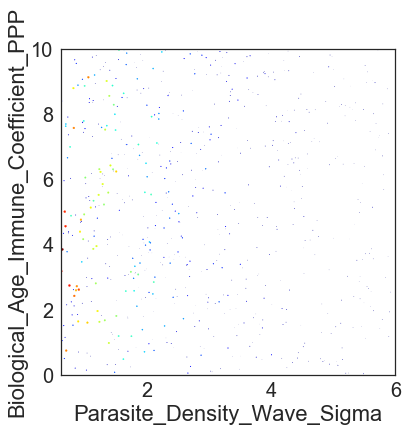

In [9]:
z = pd.merge(samples, results, on='Sample_Id') # Return to Sample_Id

#sub in variables here, can be list of tuples
xyvars = [('Parasite_Density_Wave_Sigma',	'Biological_Age_Immune_Coefficient_PPP'
)]
for (xvar, yvar) in xyvars:
    fig = plt.figure(figsize=(6,6))
    plt.scatter(z[xvar], z[yvar], c=100*z['Sim_Result'], s=5*z['Sim_Result'], cmap='jet')
    plt.xlabel(xvar); plt.ylabel(yvar)
    plt.xlim([param_info.loc[xvar, 'Min'], param_info.loc[xvar, 'Max']])
    plt.ylim([param_info.loc[yvar, 'Min'], param_info.loc[yvar, 'Max']])
    # TODO: Show as surface and plot desired result as isocline
plt.show()

In [10]:
# Finally we get to do some History Matching!
# Begin by creating an instance of the HistoryMatching class
print(type(results))
ext = 'svg' # Filetype for figures produced by history matching
hm = HistoryMatching(
    cut_name = cut_name,
    param_info = param_info,
    inputs = samples,
    results = results.squeeze(),
    desired_result = desired_result,
    desired_result_var = desired_result_std**2,
    iteration = iteration,
    implausibility_threshold = implausibility_threshold,
    discrepancy_var = discrepancy_std**2,
    training_fraction = training_fraction,
    fig_type = ext
)
hm.save() # Save to disk

<class 'pandas.core.frame.DataFrame'>
Welcome to IDM History Matching!
Found 998 unique parameter configurations, each of which is repeated 1 time(s).
--> Training with 748 unique parameter configurations ( 748  simulations including replicates)
--> Testing  with 250  unique parameter configurations ( 250 simulations including replicates)


Regularize:  0  of  15
Regularize:  1  of  15
Regularize:  2  of  15
Regularize:  3  of  15
Regularize:  4  of  15
Regularize:  5  of  15
Regularize:  6  of  15
Regularize:  7  of  15
Regularize:  8  of  15
Regularize:  9  of  15
Regularize:  10  of  15
Regularize:  11  of  15
Regularize:  12  of  15
Regularize:  13  of  15
Regularize:  14  of  15


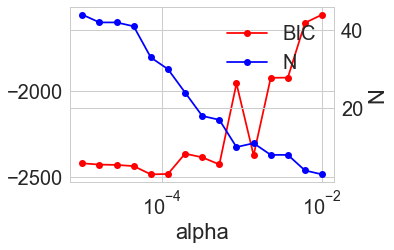

What would you like to use for the GLM regularization parameter, alpha_glm = 1e-3
User selected alpha = 0.001000
Non-Zero: 10 of 45
Regularization for GLM selected:
  * Intercept
 * Biological_Age_Immune_Coefficient_TM
 * Cumulative_Exposure_Immune_Coefficient_PPP
 * Parasite_Density_Wave_Sigma
 * Immune_Modifier_Include_Age
 * Cumulative_Exposure_Immune_Coefficient_PPP ** 2
 * Cumulative_Exposure_Immune_Coefficient_PPP * Cumulative_Exposure_Immune_Coefficient_TM
 * Cumulative_Exposure_Immune_Coefficient_PPP * Parasite_Density_Wave_Sigma
 * Cumulative_Exposure_Immune_Coefficient_PPP * Immune_Modifier_Include_Cumulative_Exposure
 * Parasite_Density_Wave_Sigma * Immune_Modifier_Include_Cumulative_Exposure


In [11]:
try:
    existing_basis = True
    need_basis = True
    with open(os.path.join('Cuts', cut_name, 'basis_glm.json')) as data_file:
        config = json.load( data_file )
        basis_glm = Basis.deserialize(config['Basis'])
        fitted_values = pd.read_json(config['Fitted_Values'], orient='split').set_index(['Sample_Id', 'Sim_Id']).squeeze()
except:
    existing_basis = False
    
if existing_basis:
    print('Found existing GLM basis with the following terms:')
    display(basis_glm.model_terms)
    reply = input('Would you like to use this basis? [Y]/n: ')
    
    if reply.lower() != 'n':
        need_basis = False
    
if need_basis:
    basis_glm = Basis.polynomial_basis(params=param_names, intercept = True, first_order=True, second_order=True, third_order=False, param_info=param_info)

    basis_glm.plot_regularize(samples, results, alpha = np.logspace(-5, -2, 15), scaleX=True)
    alpha_glm = float(input('What would you like to use for the GLM regularization parameter, alpha_glm = '))
#     alpha_glm = 1e-1
    
    fitted_values = basis_glm.regularize(samples, results, alpha = alpha_glm, scaleX=True)
    print('Regularization for GLM selected:\n', ' *','\n * '.join(basis_glm.get_terms()))
    with open(os.path.join('Cuts', cut_name, 'basis_glm.json'), 'w') as fout:
        json.dump( {
            'Basis': basis_glm.serialize(),
            'Fitted_Values': fitted_values.reset_index().to_json(orient='split')
        }, fout, indent=4)

In [12]:
# Now fit the glm and plot

### GLM ###############################################################
print("="*80, "\nGeneralized Linear Modeling\n", "="*80)
#######################################################################
f = hm.glm(
    basis = basis_glm,
    family = 'Poisson',
    force_optimize_glm = True,
    glm_fit_maxiter = 1000,
    plot = True, #force_optimize_glm,
    plot_data = True
)

Generalized Linear Modeling
Plotting


In [13]:
for file in glob.glob(fix_glob(os.path.join(hm.glmdir, "PairwiseResults", "*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

In [14]:
# Results get saved to disk, so load and display:
for file in glob.glob(fix_glob(os.path.join(hm.glmdir, "GLM Predicted vs Actual*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

..\iter1\Cuts\50_28_W2_Sugungum\GLM\GLM Predicted vs Actual.svg


In [15]:
basis_gpr = Basis.polynomial_basis(
#     params =  [
# 'Scale_Factor_Age_a', 
# 'Cumulative_Exposure_Immune_Coefficient_TM',
# 'Recent_Exposure_Immune_Coefficient_PPP',
# 'Recent_Exposure_Immune_Coefficient_TM',
# 'Parasite_Density_Wave_Sigma',
# 'Immune_Modifier_Include_Age',
# 'Immune_Modifier_Include_Strain_Diversity',
# 'Immune_Modifier_Include_Cumulative_Exposure'
#               ],
    params = param_info.index.values, 
    intercept = False, 
    first_order = True, 
    param_info=param_info)

In [16]:

### GPR ###############################################################
print("="*80, "\nGaussian Process Regression\n", "="*80)
#######################################################################
hm.gpr(
    basis = basis_gpr,
    force_optimize_gpr = True,

    sigma2_f_guess = 0.6,
    sigma2_f_bounds = (0.1, 1000),
    sigma2_n_guess =  2.0,
    sigma2_n_bounds = (0.01, 100),

    #lengthscale_guess = [7.49636161e+01 4.30910765e-02 2.18296911e+01 8.08185597e+01
#  5.86791240e-02 4.55925184e+01 7.61216580e+01 3.72424498e-01
#  9.24611775e-01 7.41104089e-01]
    lengthscale_guess = 0.25,
    lengthscale_bounds = (0.01, 100),

    optimize_sigma2_n = True,
    log_transform = False,

    verbose = True,
    optimizer_options = {
        'eps': 5e-3,
        'disp': True,
        'maxiter': 15000,
        'ftol': 2 * np.finfo(float).eps,
        'gtol': 2 * np.finfo(float).eps,
    },
    plot = True, #force_optimize_gpr,
    plot_data = False
)

Gaussian Process Regression
Fitting the GPR

	LL: 1141.5983692468467 
	Theta: [0.6  2.   0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25] 
	Deriv: [ 10.99099412 108.67840111 -36.95356001 -16.64099714  15.11460594
 -25.99813305 -21.44117793  -0.27652861  14.13386774  30.72963672]

	LL: 5893.044755436047 
	Theta: [1.00000000e-01 1.00000000e-02 3.72035600e+01 1.68909971e+01
 1.00000000e-02 2.62481331e+01 2.16911779e+01 5.26528608e-01
 1.00000000e-02 1.00000000e-02] 
	Deriv: [-3.26473921e+04 -2.81034713e+05  1.64133884e+00  7.34341138e+00
  4.41102201e+04  3.35635627e+00  2.28641696e+00  4.04495962e+03
  6.14009536e+04  6.89223083e+04]

	LL: 978.7673622934926 
	Theta: [ 0.38656154  1.15051494 16.02462173  7.35365754  0.14754954 11.34800286
  9.40274391  0.36804368  0.14754954  0.14754954] 
	Deriv: [-8.95940493e+01  1.64397921e+02 -1.91272440e-02  5.07379083e-02
  1.24369160e+02 -3.95250963e-02 -7.65024067e-02  3.34155621e+01
  8.01664856e+01  1.45338198e+02]

	LL: 939.6764041602044 
	Theta: [2.530


	LL: 260.0615183776394 
	Theta: [2.53069153e+00 1.00000000e-02 1.11653762e+01 5.16997661e+00
 3.50998701e-02 7.93237073e+00 6.58954572e+00 5.87352056e-02
 8.47733195e-02 5.66554977e-02] 
	Deriv: [ 7.15668864e-02  5.88852361e+02 -1.80939543e+00 -4.57583685e+00
 -5.63578275e+01  7.77670417e+00 -2.75228738e+00 -5.03690336e+01
  3.93962975e+00 -6.04682507e+01]

	LL: 260.0155845995385 
	Theta: [2.53026138e+00 1.00000000e-02 1.10308109e+01 5.10951804e+00
 3.50095641e-02 7.83761615e+00 6.51155936e+00 5.95095425e-02
 8.48912189e-02 5.72478819e-02] 
	Deriv: [-5.11907455e-01  5.58026760e+02 -1.82753178e+00 -4.59590383e+00
 -5.37982967e+01  7.85345010e+00 -2.75839608e+00 -6.29210788e+00
  1.18361438e+01 -2.79016017e+01]

	LL: 259.99890343288723 
	Theta: [2.53111866e+00 1.00000000e-02 1.08584557e+01 5.03208919e+00
 3.51859554e-02 7.71621290e+00 6.41167519e+00 5.96826828e-02
 8.47539973e-02 5.77915004e-02] 
	Deriv: [-5.26349763e-01  5.53442199e+02 -1.86641174e+00 -4.64808463e+00
  5.94626780e+00  


	LL: 236.13562049461837 
	Theta: [1.12679262e+01 1.00000000e-02 2.75441413e+01 1.74642441e+01
 4.83298000e-02 7.34923972e+00 1.83433967e+01 9.47187571e-02
 1.24184968e-01 7.56399739e-02] 
	Deriv: [ 4.46775504e+00  8.03528843e+02 -8.46500635e-01 -1.04086908e+00
 -6.08442647e+00  2.62158319e+00 -8.99030894e-01 -5.80445005e+00
 -1.18373117e+00  5.06692619e-01]

	LL: 236.1353197074269 
	Theta: [1.12873623e+01 1.00000000e-02 2.75810492e+01 1.74917733e+01
 4.83128057e-02 7.34836899e+00 1.83698016e+01 9.47688534e-02
 1.24070306e-01 7.58256943e-02] 
	Deriv: [  4.46208079 796.40371404  -0.84468735  -1.03780247  -8.38121393
   2.61586305  -0.89756841  -5.06394906  -3.07479658   2.98932142]

	LL: 236.1305918520569 
	Theta: [1.12194851e+01 1.00000000e-02 2.74560910e+01 1.73973933e+01
 4.83420102e-02 7.35420759e+00 1.82798641e+01 9.46965119e-02
 1.24218580e-01 7.53866643e-02] 
	Deriv: [ 4.46435924e+00  8.07921823e+02 -8.49842106e-01 -1.04661760e+00
  1.37303833e-01  2.64127330e+00 -9.01364219e-01 


	LL: 236.12794192780865 
	Theta: [1.11974759e+01 1.00000000e-02 2.74674830e+01 1.73908432e+01
 4.83269751e-02 7.39056550e+00 1.82811400e+01 9.50250459e-02
 1.24158579e-01 7.51599704e-02] 
	Deriv: [  4.41911279 793.36535346  -0.8482664   -1.04781548   4.15377838
   2.67260445  -0.89568808   7.67630312   2.01460876  -1.08059063]

	LL: 236.12472641471334 
	Theta: [1.11974003e+01 1.00000000e-02 2.74672449e+01 1.73906919e+01
 4.83269432e-02 7.39050706e+00 1.82809817e+01 9.50245970e-02
 1.24158494e-01 7.51600523e-02] 
	Deriv: [  4.41991819 793.65872665  -0.84829839  -1.04789162   4.0902212
   2.67240011  -0.89575761   7.59175564   1.99016542  -1.24424589]

	LL: 236.1123362471448 
	Theta: [1.12850347e+01 1.00000000e-02 2.77494783e+01 1.75703879e+01
 4.83409795e-02 7.45783946e+00 1.84688865e+01 9.57456196e-02
 1.24204431e-01 7.51612822e-02] 
	Deriv: [  4.31838965 755.83982941  -0.83627699  -1.03462522   4.83346883
   2.6891648   -0.8771017   24.81737595   1.94299949   3.25469629]

	LL: 236.09


	LL: 190.43133043872922 
	Theta: [5.96487632e+00 1.00000000e-02 3.60948265e+01 2.69481284e+01
 4.96362259e-02 2.03622488e+00 2.62581743e+01 9.79710716e-02
 1.27311553e-01 4.39229251e-02] 
	Deriv: [ 8.77595354e+00  1.83155594e+03 -4.23766989e-01 -4.77637571e-01
 -2.21135833e+02 -7.68175547e+00 -7.57674861e-01  3.36015888e+02
  2.50358118e+02 -1.10718994e+03]

	LL: 3251.312967007598 
	Theta: [0.1  0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01] 
	Deriv: [-27422.88577857 -27327.17896583   -507.54159041   -499.28663228
   -553.08408408   -285.61422119   -575.09597169   -230.47961114
   -593.20192861   -217.04707494]

	LL: 253.3318075961123 
	Theta: [4.03928025e+00 1.00000000e-02 2.42472109e+01 1.81036189e+01
 3.66225907e-02 1.37096095e+00 1.76401952e+01 6.90878111e-02
 8.87950262e-02 3.27851196e-02] 
	Deriv: [ 4.45018080e+01  3.02861219e+03 -7.24895134e-01 -1.07711422e+00
 -3.52251085e+03 -3.34150599e+01 -1.41150037e+00 -8.77075700e+02
 -9.92270533e+02 -4.41180914e+03]

	LL: 190.43186887448


	LL: 190.43086595991912 
	Theta: [5.96476482e+00 1.00000000e-02 3.60941405e+01 2.69476162e+01
 4.96354723e-02 2.03618635e+00 2.62576753e+01 9.79693991e-02
 1.27309323e-01 4.39222801e-02] 
	Deriv: [ 8.77851767e+00  1.83172169e+03 -4.23775945e-01 -4.77695510e-01
 -2.21341800e+02 -7.68283773e+00 -7.57706697e-01  3.35961278e+02
  2.50268569e+02 -1.10744668e+03]

	LL: 190.43086595991912 
	Theta: [5.96476482e+00 1.00000000e-02 3.60941405e+01 2.69476162e+01
 4.96354723e-02 2.03618635e+00 2.62576753e+01 9.79693991e-02
 1.27309323e-01 4.39222801e-02] 
	Deriv: [ 8.77851767e+00  1.83172169e+03 -4.23775945e-01 -4.77695510e-01
 -2.21341800e+02 -7.68283773e+00 -7.57706697e-01  3.35961278e+02
  2.50268569e+02 -1.10744668e+03]

	LL: 190.43098558703093 
	Theta: [5.96476482e+00 1.00000000e-02 3.60941405e+01 2.69476162e+01
 4.96354723e-02 2.03618635e+00 2.62576753e+01 9.79693991e-02
 1.27309323e-01 4.39222801e-02] 
	Deriv: [ 8.77754941e+00  1.83171012e+03 -4.23774491e-01 -4.77695878e-01
 -2.21361936e+02


	LL: 171.2093583115352 
	Theta: [5.61037319e+00 1.00000000e-02 3.61132209e+01 2.69632959e+01
 4.55026462e-02 2.16905635e+00 2.62827579e+01 8.21792021e-02
 9.70566607e-02 7.04571635e-02] 
	Deriv: [ 9.93146322e+00  1.67778286e+03 -4.82115371e-01 -3.68557763e-01
 -5.70845653e+02 -2.26210597e+00 -6.17567212e-01  8.36846803e+01
 -7.33328104e+01  7.89493068e+01]

	LL: 168.241356455561 
	Theta: [5.08672485e+00 1.00000000e-02 3.61413844e+01 2.69864126e+01
 4.21202656e-02 2.36400004e+00 2.63197377e+01 8.03512184e-02
 9.43598991e-02 7.04009538e-02] 
	Deriv: [ 9.81105797e+00  1.65024694e+03 -4.53966219e-01 -3.04794394e-01
 -8.57683476e+02  1.29009863e-01 -5.75009679e-01  1.27455712e+02
 -1.06973202e+02  1.50328704e+02]

	LL: 161.59023838173005 
	Theta: [3.87913818e+00 1.00000000e-02 3.62063342e+01 2.70397235e+01
 3.71270146e-02 2.81349340e+00 2.64050204e+01 7.24471868e-02
 8.93913846e-02 6.65196838e-02] 
	Deriv: [ 8.29707997e+00  1.69438127e+03 -3.97838672e-01 -1.56756026e-01
 -1.18943367e+03  4


	LL: 123.55084472594967 
	Theta: [1.46823169e+00 1.00000000e-02 3.63887191e+01 2.71196449e+01
 4.42814117e-02 1.00052807e+00 2.66484160e+01 4.38511179e-02
 6.70462389e-02 4.86062937e-02] 
	Deriv: [ 7.83486538e+00  3.85732472e+03 -2.46718316e-01 -6.32443616e-02
  1.08088022e+02  1.96564740e+00 -4.23654600e-01 -1.22888260e+01
 -2.72808499e+02 -2.59052121e+02]

	LL: 123.79797617470706 
	Theta: [1.25939773e+00 1.00000000e-02 3.64070739e+01 2.71252786e+01
 4.35878732e-02 7.11938735e-01 2.66730469e+01 3.95634477e-02
 6.57072245e-02 5.15195915e-02] 
	Deriv: [ 7.90513416e+00  3.95638028e+03 -1.93399447e-01 -1.18060000e-01
 -8.40398404e+01 -2.12810608e+01 -3.58901594e-01 -1.00537536e+02
 -5.24885214e+01 -2.00633756e+02]

	LL: 122.81934344800845 
	Theta: [1.36705570e+00 1.00000000e-02 3.63976117e+01 2.71223743e+01
 4.39454058e-02 8.60712150e-01 2.66603492e+01 4.17738251e-02
 6.63975125e-02 5.00177298e-02] 
	Deriv: [ 7.65731140e+00  3.91987444e+03 -2.22633809e-01 -8.43362983e-02
  2.60184610e+01


	LL: 122.22672474585818 
	Theta: [1.32438351e+00 1.00000000e-02 3.63995999e+01 2.71244321e+01
 4.26138952e-02 8.94423747e-01 2.66629602e+01 4.06993337e-02
 6.78156644e-02 5.20268751e-02] 
	Deriv: [-4.64812835e-02  3.80020166e+03 -2.12102499e-01 -4.39185446e-02
 -1.38347287e-02 -1.28796596e-02 -3.79216471e-01  5.89021426e-02
  7.45702501e-03 -3.95881470e-02]

	LL: 122.22672474434091 
	Theta: [1.32438351e+00 1.00000000e-02 3.63995999e+01 2.71244321e+01
 4.26138952e-02 8.94423747e-01 2.66629602e+01 4.06993337e-02
 6.78156644e-02 5.20268751e-02] 
	Deriv: [-4.64813557e-02  3.80020166e+03 -2.12102499e-01 -4.39185446e-02
 -1.38332629e-02 -1.28796643e-02 -3.79216471e-01  5.89017349e-02
  7.45919390e-03 -3.95874985e-02]

	LL: 122.22672474434091 
	Theta: [1.32438351e+00 1.00000000e-02 3.63995999e+01 2.71244321e+01
 4.26138952e-02 8.94423747e-01 2.66629602e+01 4.06993337e-02
 6.78156644e-02 5.20268751e-02] 
	Deriv: [-4.64813557e-02  3.80020166e+03 -2.12102499e-01 -4.39185446e-02
 -1.38332629e-02

C:\conda\envs\history_matching\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


In [17]:
pi = param_info.loc[basis_gpr.param_dict.keys()].reset_index()
pi['Lengthscale'] = hm.gpr_model.theta[2:]
print(pi[['Name', 'Lengthscale']].sort_values('Lengthscale'))

                                          Name  Lengthscale
5                  Parasite_Density_Wave_Sigma     0.040699
2   Cumulative_Exposure_Immune_Coefficient_PPP     0.042614
7  Immune_Modifier_Include_Cumulative_Exposure     0.052027
6                  Immune_Modifier_Include_Age     0.067816
3    Cumulative_Exposure_Immune_Coefficient_TM     0.894424
4                           Scale_Factor_Age_a    26.662960
1         Biological_Age_Immune_Coefficient_TM    27.124432
0        Biological_Age_Immune_Coefficient_PPP    36.399600


In [18]:
# Results get saved to disk, so load and display:
for file in glob.glob(fix_glob(os.path.join(hm.gprdir, "PairwiseResults", "*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

In [19]:
### Implausibility ############################################################
print("="*80, "\nImplausibility\n", "="*80)
###############################################################################
hm.calc_and_plot_implausibility(
    plot = True,
    do_plot_data = False,
    plot_data_highlight = pd.DataFrame() #hm.test_data.loc['prime.000049']
) 
    #plot_data_highlight=pd.DataFrame() # plot_data_highlight=hm.training_data.loc['prime.000049']

hm.training_data.to_excel(os.path.join('Cuts', cut_name, 'train_data.xlsx'))
hm.test_data.to_excel(os.path.join('Cuts', cut_name, 'test_data.xlsx'))

print('Good')

Implausibility
Good


In [20]:
# Results get saved to disk, so load and display:
for file in glob.glob(fix_glob(os.path.join(hm.combineddir, "*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

..\iter1\Cuts\50_28_W2_Sugungum\Implausibility\implausibility.svg


In [21]:
ar = all_results.reset_index()

data = ar.loc[ar['AgeBin']==age_bin[0]].groupby(['Sample_Id','AgeBin'])['Result'].mean().reset_index().set_index('Sample_Id')

train = hm.training_data
train['Train'] = True
test = hm.test_data
test['Train'] = False
train_test = pd.concat([train, test])

fig, ax = plt.subplots(figsize=(16,10))

# Reference
#ref_by_year = reference_data[['Prevalence']].reset_index()

ref_by_year = ref_df.loc[ref_df['Age bin'] == int(age_bin[0][:2])] \
    .groupby('Age bin') \
    .mean() \
    .reset_index()
print(ref_by_year)
print(data)
sns.lineplot(data=ref_by_year, x='Age bin', y='Mean', color='k', marker='o', alpha=1, lw=2, zorder=1);

# Sims
tmp = data.merge(train_test[['Sample_Orig', 'Implausible', 'Train']], left_on='Sample_Id', right_on='Sample_Orig')
print(tmp.head())
sns.lineplot(data=tmp, x='AgeBin', y='Result', hue='Implausible', style='Train', 
             units='Sample_Orig', estimator=None, alpha=0.5, lw=0.5,
             ax=ax, zorder=-1)
ax.set_xlabel('AgeBin');
ax.set_ylabel('Duration');
ax.set_xticks(ref_by_year['Age bin'].unique());

KeyError: 'AgeBin'